In [1]:
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets
from torchvision import transforms

In [2]:
data_dir = '../data/gray_formatted/'
batch_size = 8
n_workers = 4
n_epochs = 500
lr = 0.001
img_dim = 64
display_delay = 999999

In [3]:
def input_transform(img):
    img = np.array(img)[:, :, 0]
    target, outline = np.split(img, 2, axis=1)
    target = transforms.ToTensor()(target)
    outline = transforms.ToTensor()(outline)
    return outline, target

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=input_transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=n_workers)

def get_generator():
    data_iter = iter(dataloader)
    for (X, y), _ in data_iter:
        yield X, y

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # 1 x 64 x 64 input
        # Downscale
        self.ds1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.ds2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.ds3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.4))
        
        # Upscale
        self.us1 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
            nn.ReLU())
        self.us2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.us3 = nn.Sequential(
            nn.Conv2d(8, 1, kernel_size=5, stride=1, padding=2),
            nn.Upsample(scale_factor=2))
        
        self.detail = nn.Conv2d(1, 1, kernel_size=5, stride=1, padding=2)
        
    def forward(self, x):
        # Downscale
        z1 = self.ds1(x)
        z2 = self.ds2(z1)
        z3 = self.ds3(z2)
        
        z4 = self.us1(z3) + z2
        z5 = self.us2(z4) + z1
        z6 = self.us3(z5) + x
        
        raw = self.detail(z6)
        
        out = torch.clamp(raw, 0, 1)
        
        return out

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 1 x 64 x 64 input
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Linear(16 * 2 * 2, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        z = self.layer1(x)
        z = self.layer2(z)
        z = self.layer3(z)
        z = self.layer4(z).view(x.shape[0], -1)
        prob = self.layer5(z)
        
        return prob

In [7]:
def calc_loss(x, y, gen, disc):
    real_input = torch.stack((x, y), dim=1).squeeze()
    fake_input = torch.stack((x, gen(x)), dim=1).squeeze()
    
    real_prob = disc(real_input)
    fake_prob = disc(fake_input)
    
    gen_loss = -torch.log(fake_prob)
    gen_loss = torch.mean(gen_loss.view(-1))
    
    disc_loss = -torch.log(real_prob) - torch.log(1 - fake_prob)
    disc_loss = torch.mean(disc_loss.view(-1))
    
    return gen_loss, disc_loss

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.train()
discriminator.train()

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

gen_losses = []
disc_losses = []

for epoch in range(n_epochs):
    print(f'Starting epoch #{epoch+1}')
    
    data_gen = get_generator()
    for step, (X, y) in enumerate(data_gen):
        X = X.to(device)
        y = y.to(device)

        gen_optimizer.zero_grad()
        disc_optimizer.zero_grad()

        gen_loss, disc_loss = calc_loss(X, y, generator, discriminator)
        
        gen_losses.append(gen_loss.detach().numpy())
        disc_losses.append(disc_loss.detach().numpy())

        if step > 0 and step % display_delay == 0:
            print(f'Step #{step} | gen_loss: {np.mean(gen_losses[-display_delay:])} | disc_loss: {np.mean(disc_losses[-display_delay:])}')

        gen_loss.backward(retain_graph=True)
        gen_optimizer.step()
        
        disc_loss.backward()
        disc_optimizer.step()
        
    print(f'Epoch #{epoch+1} | gen_loss: {np.mean(gen_losses[-step:])} | disc_loss: {np.mean(disc_losses[-step:])}')

Starting epoch #1
Epoch #1 | gen_loss: 0.6799740791320801 | disc_loss: 0.7407511472702026
Starting epoch #2
Epoch #2 | gen_loss: nan | disc_loss: nan
Starting epoch #3
Epoch #3 | gen_loss: nan | disc_loss: nan
Starting epoch #4
Epoch #4 | gen_loss: nan | disc_loss: nan
Starting epoch #5
Epoch #5 | gen_loss: nan | disc_loss: nan
Starting epoch #6
Epoch #6 | gen_loss: nan | disc_loss: nan
Starting epoch #7
Epoch #7 | gen_loss: nan | disc_loss: nan
Starting epoch #8
Epoch #8 | gen_loss: nan | disc_loss: nan
Starting epoch #9
Epoch #9 | gen_loss: nan | disc_loss: nan
Starting epoch #10
Epoch #10 | gen_loss: nan | disc_loss: nan
Starting epoch #11
Epoch #11 | gen_loss: nan | disc_loss: nan
Starting epoch #12
Epoch #12 | gen_loss: nan | disc_loss: nan
Starting epoch #13
Epoch #13 | gen_loss: nan | disc_loss: nan
Starting epoch #14
Epoch #14 | gen_loss: nan | disc_loss: nan
Starting epoch #15
Epoch #15 | gen_loss: nan | disc_loss: nan
Starting epoch #16
Epoch #16 | gen_loss: nan | disc_loss: 

KeyboardInterrupt: 

In [12]:
X[i:i+1]

tensor([], size=(0, 1, 64, 64))

In [14]:
X[0:1]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 1., 1., 0.],
          [0., 1., 1.,  ..., 1., 1., 0.],
          ...,
          [0., 1., 1.,  ..., 1., 1., 0.],
          [0., 1., 1.,  ..., 1., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [13]:
generator(X[0:1])

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]], grad_fn=<ClampBackward>)

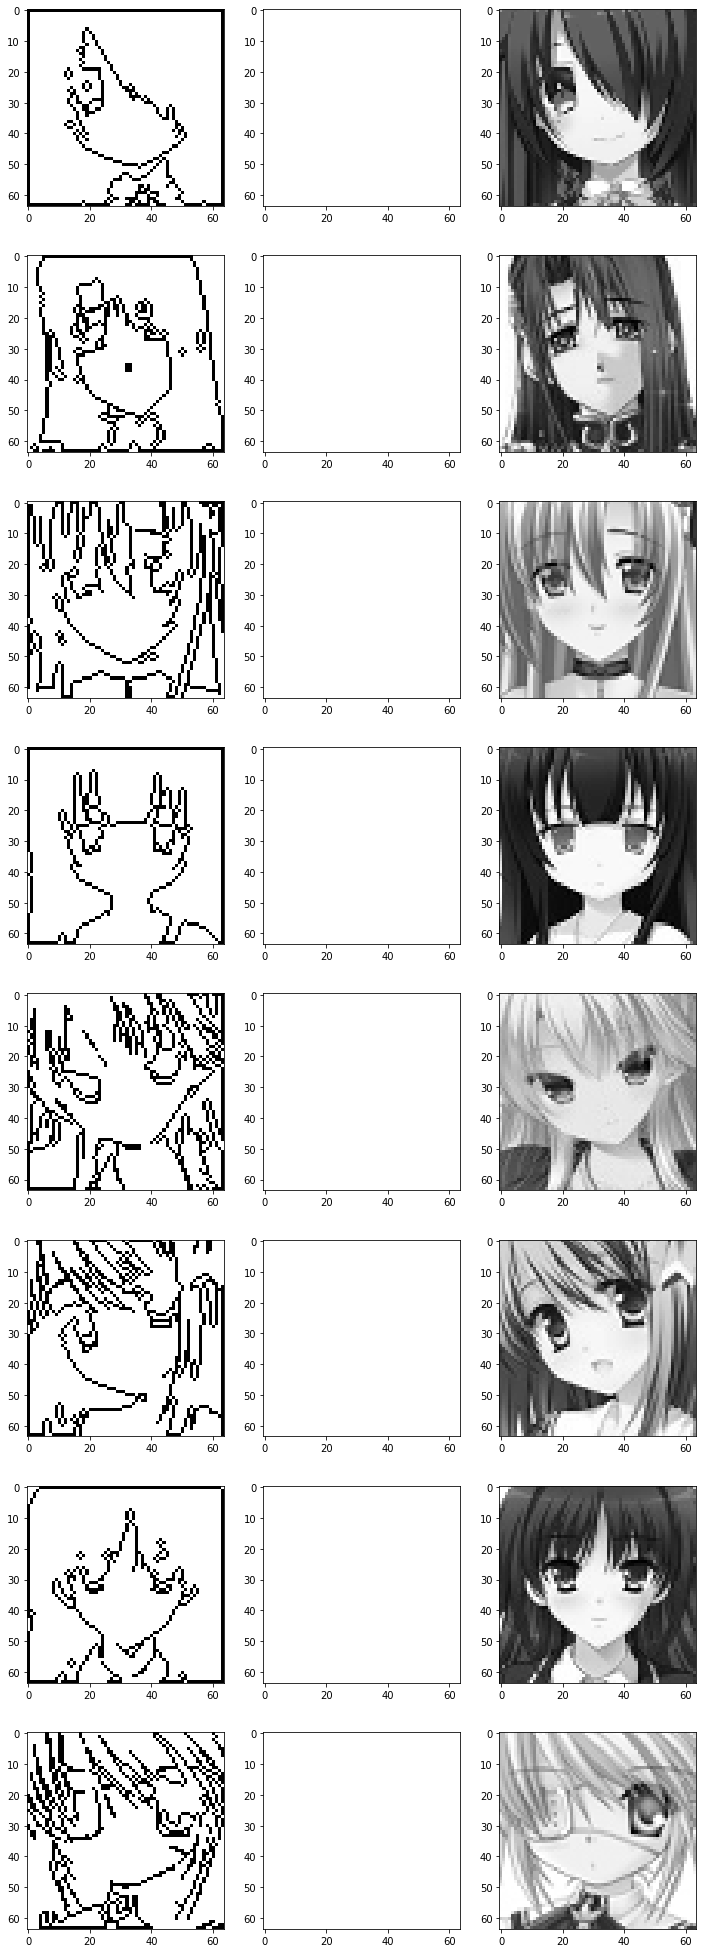

In [10]:
generator.eval()
data_gen = get_generator()
X, y = next(data_gen)

example_imgs = []

for i in range(batch_size):
    outline = X[i].squeeze().detach().numpy()
    img = generator(X[i:i+1]).squeeze().detach().numpy()
    actual = y[i].squeeze().detach().numpy()
    
    example_imgs.append(outline)
    example_imgs.append(img)
    example_imgs.append(actual)

plt.figure(figsize=(12, batch_size * 5))
columns = 3
for i, img in enumerate(example_imgs):
    plt.subplot(len(example_imgs) / columns + 1, columns, i + 1)
    plt.imshow(img, cmap='gray')